In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 
import pprint
import csv
from tqdm import tqdm

In [2]:
def whole_image_avg(t):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

    temp = torch.squeeze(t).permute(1,2,0).to(device)
    avg = torch.zeros((2048)).cpu().to(device)
    for i in range(temp.size()[0]):
        for j in range(temp.size()[1]):
            avg += temp[i][j]
    avg = torch.div(avg, temp.size()[0]* temp.size()[1])
    return avg

In [3]:
def imgs_for_hotel(p):
    same_hotel = {}
    for root, dirs, files in os.walk(os.path.join(p)):
        for d in dirs:
            for rs, ds, fs in os.walk(os.path.join(root, d)):
                t = []
                fs.sort(key=lambda f: os.path.splitext(f))
                for f in fs:
                    if "pt" in f or "csv" in f:
                        t.append(os.path.join(rs, f))
                # same_hotel[h][d] = t
                same_hotel[d] = t
    return same_hotel

In [4]:
def get_pairs(rooms):
    num_rooms = len(rooms.keys())
    hotel_id = [f for f in range(num_rooms)]
    book_dict = dict(zip(hotel_id, rooms))
    ids = list(rooms.keys())

    pairs = []
    for i, v in enumerate(ids):
        for j in ids[i+1:]:
            pairs.append((ids[i], j))
    return pairs

In [1]:
def calculate_hist(data):
    vals = [f[0] for f in data[k]]
    p = plt.hist(vals, bins=15, histtype="stepfilled", alpha=0.3, color="r", density=True, label="Similarity Between Images of The Same Room")
    plt.savefig("hists/1/similarity_same_room.png")

In [6]:
def cos_sim(pairs, rooms):
    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

    pair_cos = {}
    for pair in pairs:
        h1 = torch.load(rooms[pair[0]][2]); h2 = torch.load(rooms[pair[1]][2])
        h1 = whole_image_avg(h1); h2 = whole_image_avg(h2)

        pair_cos[pair[0] + "-" + pair[1]] = float(cos(h1, h2)) 
    return pair_cos

In [ ]:
def comp():
    hist = None
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # structure-->chain-->hotel-->similarity: (similarity for that hotel, the averaged vector for that hotel)
    # so similarity of the rooms in a certain hotel
    Similarity = {}
    for _, chains, __ in os.walk("features2"):
        chains = sorted(chains)
        for ch in tqdm(chains[1:2], desc="Chains"):
            Similarity[ch] = {}
            for root, hotels, ___ in list(os.walk(os.path.join("features2", ch))):
                hotels = sorted(hotels)
                hotel_self_similarity = None
                hotel_vector = torch.zeros((2048)).to(device)
                for h in tqdm(hotels, desc="Hotels"):
                    rooms = imgs_for_hotel(os.path.join(root, h))
                    pairs = get_pairs(rooms)
                    for r in rooms.keys():
                        hotel_vector += whole_image_avg(torch.load(rooms[r][2]))
                    if not pairs:
                        continue
                    p_c = cos_sim(pairs, rooms)
                    # print("Chain: {}; ID: {}; AVG Sim: {}".format(ch, h, hotel_self_similarity))
                    hotel_self_similarity = sum(p_c.values()) / len(p_c.values())
                    # hist = calculate_hist(p_c)
                    Similarity[ch][h] = (hotel_self_similarity,hotel_vector / len(rooms.keys()))
    return Similarity
                    

In [15]:
%matplotlib inline
result = comp()
for k in result.keys():
    calculate_hist(result[k])

Chains:   0%|          | 0/1 [00:30<?, ?it/s]


KeyboardInterrupt: 

In [13]:
h2 = comp()

In [13]:
p_c.values()

NameError: name 'p_c' is not defined

In [36]:
same_hotel = {}
for root, dirs, files in os.walk(os.path.join("features2/-1/401")):
    for d in dirs:
        for rs, ds, fs in os.walk(os.path.join(root, d)):
            t = []
            fs.sort(key=lambda f: os.path.splitext(f))
            for f in fs:
                if "pt" in f or "csv" in f:
                    t.append(os.path.join(rs, f))
            # same_hotel[h][d] = t
            same_hotel[d] = t


In [37]:
%matplotlib inline
pd.options.display.max_colwidth=500

In [38]:
num_rooms = len(same_hotel.keys())
hotel_id = [f for f in range(num_rooms)]
book_dict = dict(zip(hotel_id, same_hotel))
ids = list(same_hotel.keys())

In [39]:
pairs = []
for i, v in enumerate(ids):
    for j in ids[i+1:]:
        pairs.append((ids[i], j))

In [33]:
pair_cos = {}


In [40]:
pair_cos2= {}

In [41]:
for pair in pairs:
    with open(same_hotel[pair[0]][0], 'r') as csv1, open(same_hotel[pair[1]][0], 'r') as csv2:
        reader1 = csv.reader(csv1, delimiter=",")
        reader2 = csv.reader(csv2, delimiter=",")
        next(reader1); next(reader2)

        for idx1, row1 in enumerate(reader1):
            for idx2, row2 in enumerate(reader2):
                if row1[1] == row2[1]:
                    h1 = torch.load(same_hotel[pair[0]][2]); h2 = torch.load(same_hotel[pair[1]][2])
                    h1 = whole_image_avg(h1); h2 = whole_image_avg(h2)
                    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
                    pair_cos2[pair[0] + "-" + pair[1]] = float(cos(h1, h2))        

In [49]:
a = whole_image_avg(torch.load('features2/-1/397/2610825/fts_2048.pt'))
b = whole_image_avg(torch.load('features2/92/510/3870302/fts_2048.pt'))

cos(a, b)

tensor(0.5186, device='cuda:0')

In [50]:
a = torch.load("/pless_nfs/home/mdt_/Hotels50-FeatureComputation/features2/-1/1225/2620908/fts.pt")
b = torch.load("/pless_nfs/home/mdt_/Hotels50-FeatureComputation/features2/-1/397/2610825/fts.pt")
cos(b[0], a[1])

tensor(0.6500)

In [43]:
temp = torch.zeros((2048))
temp2 = torch.zeros((2048))

for k in pair_cos.keys():
    for k2 in pair_cos2.keys():
        

In [94]:
keys = list(pair_cos.keys())
vals = list(pair_cos.values())

<BarContainer object of 3 artists>

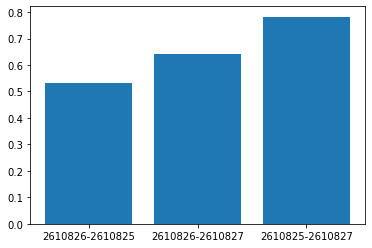

In [95]:
plt.bar(keys, vals, label="sim")

In [1]:
import pickle
with open("feature_dict.pckl", "rb") as p:
    data = pickle.load(p)



In [11]:
keys = list(data['0'].keys())
vals = [f[0] for f in data['0'].values()]

<BarContainer object of 97 artists>

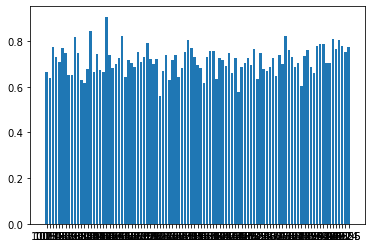

In [12]:
plt.bar(keys, vals, label="sim")


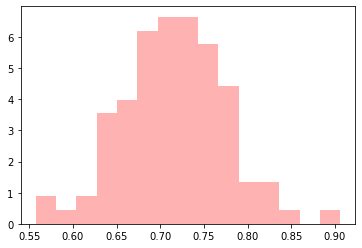

In [28]:
p = plt.hist(vals, bins=15, histtype="stepfilled", alpha=0.3, color="r", density=True, label="Similarity Between Images of The Same Room")
plt.savefig("hists/1/similarity_same_room.png")

In [4]:
data['0'].keys()

dict_keys(['10050', '10115', '107983', '109088', '113969', '114350', '115227', '12163', '123647', '127697', '12930', '130834', '13375', '133895', '134106', '134408', '13612', '137774', '139880', '140289', '141891', '144915', '14741', '14758', '15647', '16054', '16157', '16779', '1790', '18305', '18582', '18799', '19928', '20091', '20363', '20697', '20787', '21148', '21600', '22269', '22721', '23106', '23841', '25703', '2581', '26299', '26386', '27613', '31003', '31533', '32684', '33103', '34210', '35326', '36641', '37907', '38713', '38872', '39351', '39637', '39649', '40323', '41408', '4180', '42597', '45113', '46383', '46539', '5024', '5246', '53322', '5438', '55527', '59791', '60152', '6058', '60588', '64907', '6821', '73732', '7643', '78459', '80863', '82492', '8255', '82845', '8537', '87029', '89403', '90373', '9376', '94046', '94132', '9492', '97914', '98855', '9926'])